In [1]:
import json
import os
from datetime import datetime

import pandas as pd
import torch
from torch.utils.data import DataLoader

from datasets.SlideSeperatedCSVDataset import SlideSeperatedCSVDataset
from extractors.TemplateMatchExtractor import TemplateMatchExtractor, generate_dataset_from_slides
from labelers.GroundTruthLabeler import GroundTruthLabeler
from models.mlp import MLPBinaryClassifier
from models.resnet import Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier
from stopper.EarlyStopper import EarlyStopper
from test import test_classifier, plot_pr_curve
from train import train_classifier
from utils import extract_features_from_dataset
from utils import plot_model_metrics
from utils import split_dataset


In [2]:
slides_root_dir = "data/whole-slides/gut"
labels_root_dir = "data/labels"
candidates_dataset_dir = "output/candidates"
model_output_dir = "output/models"
PretrainedModelClass = Resnet101BinaryClassifier
pretrained_model_name = PretrainedModelClass.get_pretrained_model_name()
pretrained_output_size = PretrainedModelClass.pretrained_output_size
features_csv_file_name = f"{PretrainedModelClass.get_pretrained_model_name()}_{pretrained_output_size}_features.csv"
print(f"{pretrained_model_name}: {pretrained_output_size} features")

Resnet101: 2048 features


In [3]:
ground_truth_labeler = GroundTruthLabeler(f"{labels_root_dir}/slide-annotations/all.json",
                                          f"{labels_root_dir}/patch-classifications.csv")
extractor = TemplateMatchExtractor(ground_truth_labeler)
generate_dataset_from_slides(slides_root_dir, extractor, candidates_dataset_dir)

Found cached candidates dataset output/candidates


In [4]:
extract_features_from_dataset(candidates_dataset_dir,
                              [Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier])

Device: cuda:0
Found cached output/candidates/Resnet18_512_features.csv
Found cached output/candidates/Resnet50_2048_features.csv
Found cached output/candidates/Resnet101_2048_features.csv


In [5]:
def split_data(dataframe, train_portion=0.7):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for category in dataframe['quartile'].unique():
        category_slides = dataframe[dataframe['quartile'] == category]
        train_samples = category_slides.sample(frac=train_portion)
        test_samples = category_slides.drop(train_samples.index)
        train_set = pd.concat([train_set, train_samples])
        test_set = pd.concat([test_set, test_samples])
    return train_set, test_set


if os.path.exists("output/models/data-split.json"):
    with open(f"{model_output_dir}/data-split.json", 'r') as f:
        backup = json.load(f)
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = set(backup["train_slides"]), set(backup["test_slides"])
    if train_slides.union(test_slides) != set(slides_df["slide_name"]) or len(
            train_slides.intersection(test_slides)) > 0:
        raise ValueError("Invalid train test split")
    train_slides = slides_df[slides_df['slide_name'].isin(train_slides)]
    test_slides = slides_df[slides_df['slide_name'].isin(test_slides)]
else:
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = split_data(slides_df)
    with open(f"{model_output_dir}/data-split.json", 'w') as f:
        json.dump({
            "train_slides": list(train_slides["slide_name"]),
            "test_slides": list(test_slides["slide_name"])
        }, f)

print("Train Slides")
train_slides

Train Slides


,slide_name,n_gt_positive_regions,category
0,593454,22,2
1,593433,3,1
3,593439,31,2
4,593445,107,4
5,593447,25,2
6,593450,56,3
7,593451,1,1
8,593440,85,3
10,593452,336,4
13,593441,4,1


In [6]:
print("Test Slides")
test_slides

Test Slides


,slide_name,n_gt_positive_regions,category
2,593436,170,4
9,593446,15,1
11,593453,19,2
12,522021,3,1
15,593434,27,2
16,593435,109,4
20,593437,94,3


In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 4096
# dataset = SlideSeperatedImageDataset(candidates_dataset_dir, set(train_slides["slide_name"]))
dataset = SlideSeperatedCSVDataset(f"{candidates_dataset_dir}/{features_csv_file_name}",
                                   set(train_slides["slide_name"]))
# dataset = reduce_dataset(dataset, discard_ratio=0.0)

print(f"All dataset: {int(sum(dataset.labels)):,} positive, {len(dataset.labels):,} negative")


Device: cuda:0
All dataset: 702 positive, 71,534 negative


In [8]:
train_dataset, validation_dataset = split_dataset(dataset, train_ratio=0.9)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=True, )
print(f"Dataset: {len(train_dataset):,} training, {len(validation_dataset):,} validation")
print(f"Training: {int(sum(train_dataset.labels)):,d} positive, {len(train_dataset.labels):,} negative")
print(f"Validation: {int(sum(validation_dataset.labels)):,d} positive, {len(validation_dataset.labels):,} negative")

Dataset: 64,380 training, 7,154 validation
Training: 632 positive, 64,380 negative
Validation: 70 positive, 7,154 negative


In [9]:
# (hidden_layers=1, units=2048, dropout=0.1, threshold=0.5, learning_rate=3e-05, weight_decay=0.0, focal_alpha=0.75, focal_gamma=2.5)
model = MLPBinaryClassifier(in_features=pretrained_output_size, hidden_layers=1,
                            units_per_layer=2048,
                            dropout=0.1, focal_alpha=0.75, focal_gamma=2.5)

print(model)

MLPBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2048, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [10]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-02-09T17:51:25.223033


In [11]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, validation_loader, device,
                                        start_learning_rate=0.000050,
                                        min_learning_rate=0.000010,
                                        lr_warmup_steps=10,
                                        max_epochs=50,
                                        checkpoint_every=1,
                                        eval_every=1,
                                        early_stopper=EarlyStopper(patience=5, min_delta=1e-4)
                                        )

Epoch 1 training: 100%|██████████| 16/16 [00:02<00:00,  7.32it/s]


Train: 1/50: lr: 0.000050000000 loss:0.012260635907296091


Epoch 1 testing: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


Test: 1/50: loss:0.007927545346319675, accuracy:0.9902948912177076, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.16520579159259796, pr_auc:0.017606619986179267, epoch:1


Epoch 2 training: 100%|██████████| 16/16 [00:01<00:00,  8.07it/s]


Train: 2/50: lr: 0.000050000000 loss:0.006698350654914975


Epoch 2 testing: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Test: 2/50: loss:0.005819943035021424, accuracy:0.9899634092441956, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.23142968863248825, pr_auc:0.10529970141547744, epoch:2


Epoch 3 training: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s]


Train: 3/50: lr: 0.000050000000 loss:0.00528385752113536


Epoch 3 testing: 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


Test: 3/50: loss:0.004781184019520879, accuracy:0.9900877149842626, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.1828552857041359, pr_auc:0.13240243270979146, epoch:3


Epoch 4 training: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]


Train: 4/50: lr: 0.000050000000 loss:0.004434390371898189


Epoch 4 testing: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


Test: 4/50: loss:0.0043056870345026255, accuracy:0.9899634092441956, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.16877364367246628, pr_auc:0.18400749071679134, epoch:4


Epoch 5 training: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]


Train: 5/50: lr: 0.000050000000 loss:0.003974092862335965


Epoch 5 testing: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Test: 5/50: loss:0.004120400408282876, accuracy:0.9899242094250735, precision:0.25, recall:0.029411764705882353, f1:0.05263157894736842, mcc:0.08363197055745435, ece:0.14478197693824768, pr_auc:0.1982260818443508, epoch:5


Epoch 6 training: 100%|██████████| 16/16 [00:03<00:00,  4.81it/s]


Train: 6/50: lr: 0.000050000000 loss:0.003723111658473499


Epoch 6 testing: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Test: 6/50: loss:0.003957264241762459, accuracy:0.9897584684383176, precision:0.5666666666666667, recall:0.11437908496732026, f1:0.18451749734888653, mcc:0.24461419173045984, ece:0.13360684365034103, pr_auc:0.2410311058243786, epoch:6


Epoch 7 training: 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]


Train: 7/50: lr: 0.000050000000 loss:0.0035216636897530407


Epoch 7 testing: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


Test: 7/50: loss:0.003969025565311313, accuracy:0.9896755979449394, precision:0.4722222222222222, recall:0.13192721257237386, f1:0.20528455284552843, mcc:0.2450553836022225, ece:0.12751930207014084, pr_auc:0.27355501242484637, epoch:7


Epoch 8 training: 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]


Train: 8/50: lr: 0.000050000000 loss:0.003346168901771307


Epoch 8 testing: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


Test: 8/50: loss:0.0037670768797397614, accuracy:0.9903755262835187, precision:0.5079365079365079, recall:0.16666666666666666, f1:0.25096525096525096, mcc:0.28725738885482766, ece:0.1229567863047123, pr_auc:0.2827327340928961, epoch:8


Epoch 9 training: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


Train: 9/50: lr: 0.000050000000 loss:0.0031647952419007197


Epoch 9 testing: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Test: 9/50: loss:0.003535532974638045, accuracy:0.9905390318427076, precision:0.55, recall:0.23750000000000002, f1:0.32741935483870965, mcc:0.35466614126431, ece:0.12138011306524277, pr_auc:0.337040397221565, epoch:9


Epoch 10 training: 100%|██████████| 16/16 [00:03<00:00,  4.30it/s]


Train: 10/50: lr: 0.000049890438 loss:0.00298899007611908


Epoch 10 testing: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


Test: 10/50: loss:0.0035013239830732346, accuracy:0.9908246077143967, precision:0.5586206896551724, recall:0.3375, f1:0.4173913043478261, mcc:0.42809630570564094, ece:0.1220134049654007, pr_auc:0.3665341815131241, epoch:10


Epoch 11 training: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]


Train: 11/50: lr: 0.000049562952 loss:0.002805775438901037


Epoch 11 testing: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Test: 11/50: loss:0.0033156847348436713, accuracy:0.9906633375827747, precision:0.53125, recall:0.3294573643410853, f1:0.40648542417294464, mcc:0.41384522812081426, ece:0.12025496736168861, pr_auc:0.3956095560037055, epoch:11


Epoch 12 training: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Train: 12/50: lr: 0.000049021130 loss:0.0026316133880754933


Epoch 12 testing: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Test: 12/50: loss:0.003280138596892357, accuracy:0.9911908186518967, precision:0.588095238095238, recall:0.3513986013986014, f1:0.4315159574468085, mcc:0.4459665761047551, ece:0.10767701640725136, pr_auc:0.41660676668645913, epoch:12


Epoch 13 training: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]


Train: 13/50: lr: 0.000048270909 loss:0.0024635074514662847


Epoch 13 testing: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Test: 13/50: loss:0.0031703083077445626, accuracy:0.9913957594577747, precision:0.6068111455108359, recall:0.32080419580419584, f1:0.41565153193060167, mcc:0.4350907596669197, ece:0.10202592611312866, pr_auc:0.40768108345136433, epoch:13


Epoch 14 training: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Train: 14/50: lr: 0.000047320508 loss:0.002310318566742353


Epoch 14 testing: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Test: 14/50: loss:0.0030998954316601157, accuracy:0.9896823042276406, precision:0.4722222222222222, recall:0.44706368899917287, f1:0.4592349726775956, mcc:0.4542365675841976, ece:0.10807931050658226, pr_auc:0.4232219770649218, epoch:14


Epoch 15 training: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Train: 15/50: lr: 0.000046180340 loss:0.0021561535613727756


Epoch 15 testing: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Test: 15/50: loss:0.0031960327178239822, accuracy:0.9904975965960187, precision:0.5201288244766505, recall:0.375, f1:0.43537031822021965, mcc:0.4367956963273628, ece:0.09476525336503983, pr_auc:0.4180147911621516, epoch:15


Epoch 16 training: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Train: 16/50: lr: 0.000044862897 loss:0.002018591061641928


Epoch 16 testing: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Test: 16/50: loss:0.003207322326488793, accuracy:0.9911493834052076, precision:0.5413533834586466, recall:0.36493987049028676, f1:0.43333333333333335, mcc:0.43888131107468464, ece:0.08887918666005135, pr_auc:0.3914795512762086, epoch:16


Epoch 17 training: 100%|██████████| 16/16 [00:04<00:00,  3.91it/s]


Train: 17/50: lr: 0.000043382612 loss:0.0018849038970074616


Epoch 17 testing: 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Test: 17/50: loss:0.0030626108637079597, accuracy:0.9909903487011527, precision:0.5357142857142857, recall:0.4474590869939707, f1:0.4793148880105402, mcc:0.48099473849374264, ece:0.08434237539768219, pr_auc:0.4376874795635359, epoch:17


Epoch 18 training: 100%|██████████| 16/16 [00:02<00:00,  7.79it/s]


Train: 18/50: lr: 0.000041755705 loss:0.0017781574206310324


Epoch 18 testing: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Test: 18/50: loss:0.0031080746557563543, accuracy:0.9899264448526406, precision:0.45302619692863594, recall:0.45, f1:0.44493804068272147, mcc:0.44322797103121664, ece:0.09087682142853737, pr_auc:0.39452101752456314, epoch:18


Epoch 19 training: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Train: 19/50: lr: 0.000040000000 loss:0.0016463546198792756


Epoch 19 testing: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Test: 19/50: loss:0.0032053209142759442, accuracy:0.9905020674511527, precision:0.5075075075075075, recall:0.4816433566433566, f1:0.4928954111344048, mcc:0.4889677375436231, ece:0.0802239216864109, pr_auc:0.4291671853634238, epoch:19


Epoch 20 training: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


Train: 20/50: lr: 0.000038134733 loss:0.001526070678664837


Epoch 20 testing: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]


Test: 20/50: loss:0.0035483925603330135, accuracy:0.9910665129118297, precision:0.5733333333333333, recall:0.3980263157894737, f1:0.468590831918506, mcc:0.47277340470937645, ece:0.07163562253117561, pr_auc:0.417155539803293, epoch:20


Epoch 21 training: 100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Train: 21/50: lr: 0.000036180340 loss:0.0014706323490827344


Epoch 21 testing: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Test: 21/50: loss:0.0034923292696475983, accuracy:0.9909858778460187, precision:0.5527777777777778, recall:0.4338296112489661, f1:0.4823529411764706, mcc:0.48336756440824175, ece:0.0704147182404995, pr_auc:0.4158369463128484, epoch:21


Epoch 22 training: 100%|██████████| 16/16 [00:02<00:00,  7.56it/s]


Train: 22/50: lr: 0.000034158234 loss:0.001373803948808927


Epoch 22 testing: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


Test: 22/50: loss:0.003284052014350891, accuracy:0.9898872450335187, precision:0.4847198641765704, recall:0.4761513157894737, f1:0.4803675856307435, mcc:0.4752963975314569, ece:0.07446274906396866, pr_auc:0.42828215542759274, epoch:22


Training ends 2025-02-09T17:52:55.427297


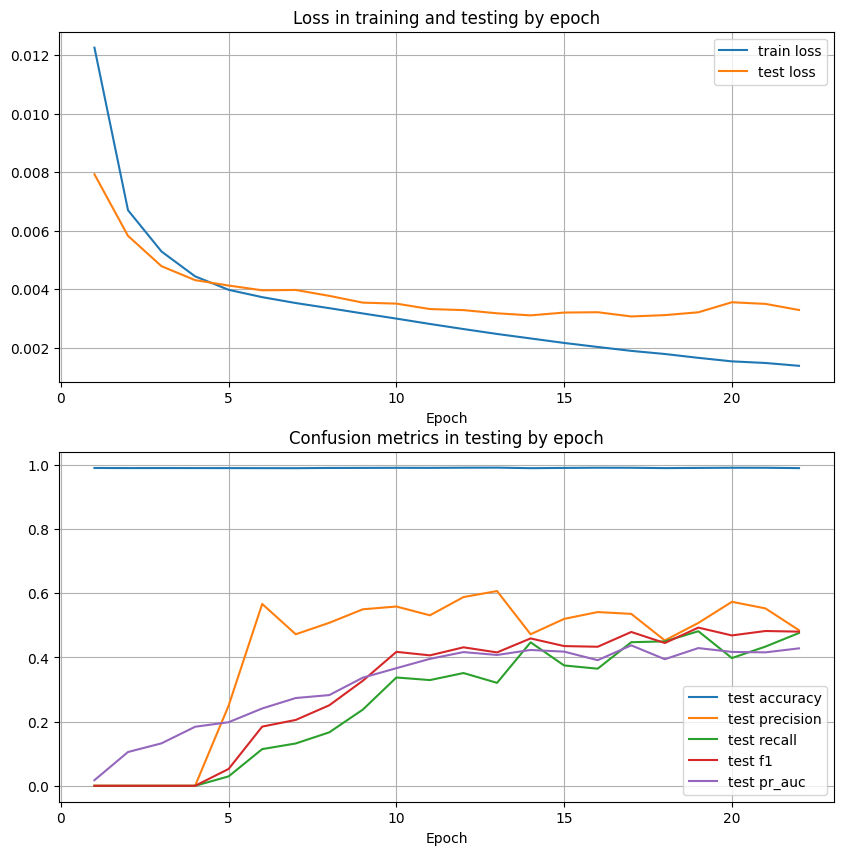

In [12]:
print(f"Training ends {datetime.now().isoformat()}")
plot_model_metrics(model_metrics)

In [13]:
validation_metrics = test_classifier(model, validation_dataset, device=device, batch_size=4096)

Testing: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


In [14]:
for metric in validation_metrics.keys():
    if validation_metrics[metric] is not None:
        print(f"Validation {metric}:", validation_metrics[metric])


Validation loss: 0.003252515336498618
Validation accuracy: 0.9899357003075203
Validation precision: 0.4857142857142857
Validation recall: 0.4857142857142857
Validation f1: 0.4857142857142857
Validation mcc: 0.4806324110671937
Validation ece: 0.07371217012405396
Validation pr_auc: 0.41142461763232546
Validation optimal_threshold: 0.4985707
Validation precisions: [0.00978474 0.0097861  0.00978747 ... 0.5        1.         1.        ]
Validation recalls: [1.         1.         1.         ... 0.01428571 0.01428571 0.        ]


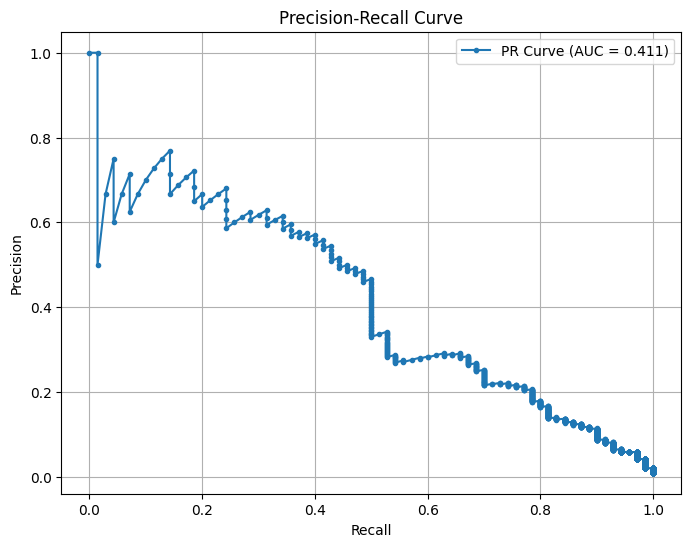

In [15]:
plot_pr_curve(validation_metrics["precisions"], validation_metrics["recalls"])

In [16]:
os.makedirs(model_output_dir, exist_ok=True)
torch.save({
    "model": model,
    "optimal_threshold": validation_metrics["optimal_threshold"]
}, f"{model_output_dir}/{pretrained_model_name}.pickle")